###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, heterogeneous models are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac2d_heterogeneous.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Florian Wölfl and Lion Krischer ([@krischer](https://github.com/krischer)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/), notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D acoustic FD modelling for heterogeneous media

So far, we only compared 2D acoustic FD modelling results for homogeneous acoustic media with analytical solutions. Next, we want to model some more interesting, heterogeneous problems. 

First, we modify our 2D acoustic FD modelling code to handle heterogeneous media and plot some nice colorful wave propagation movies:

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Definition of initial modelling parameters
# ------------------------------------------
xmax = 2000.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax   # maximum spatial extension of the 1D model in z-direction (m)
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

tmax = 0.75    # maximum recording time of the seismogram (s)
dt   = 0.0010 # time step

vp0  = 3000.  # P-wave speed in medium (m/s)

# acquisition geometry
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

f0   = 100.0 # dominant frequency of the source (Hz)
t0   = 0.1   # source time shift (s)

isnap = 2  # snapshot interval (timesteps)

In [4]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz   

In [5]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(dt,dx,dz,f0):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define model
    # ------------    
    vp  = np.zeros((nx,nz))
    vp  = model(nx,nz,vp,dx,dz)    
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros((1, nt)) 
    
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3.5))  # define figure size
    plt.tight_layout()
    extent = [0.0,xmax,0.0,zmax]     # define model extension
    
    # Plot pressure wavefield movie
    ax1 = plt.subplot(121)
    image = plt.imshow(p, animated=True, cmap="RdBu", extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)        
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    #plt.gca().invert_yaxis()
    
    # Plot Vp-model
    ax2 = plt.subplot(122)
    image1 = plt.imshow(vp/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                        extent=extent)
    
    plt.title('Vp-model')
    plt.xlabel('x [m]')    
    #plt.gca().invert_yaxis()
    plt.setp(ax2.get_yticklabels(), visible=False) 
    
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(image1, cax=cax2)         
    plt.ion()    
    plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        d2px, d2pz = update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # display pressure snapshots 
        if (it % isnap) == 0:
            image.set_data(p)
            fig.canvas.draw()             

## Problem 1: Homogeneous Model

As a reference, we start with a problem, which should be quite familiar to you - the homogeneous model. I modified the FD code to define models in a separate Python function:

In [6]:
# Homogeneous model
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 
    
    return vp

Time to define the modelling parameters and run the new FD code ...

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


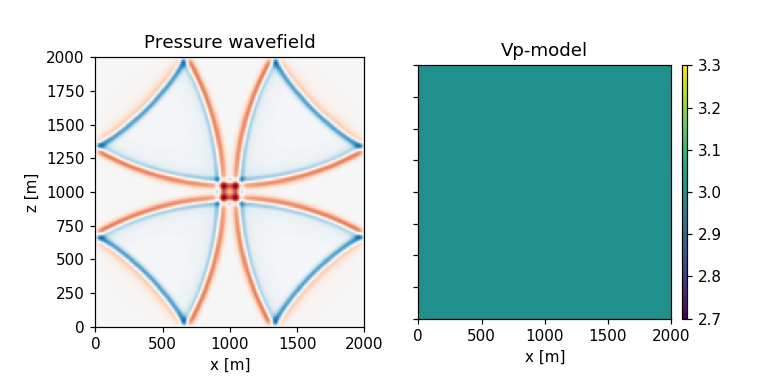

In [7]:
%matplotlib notebook
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vp0)

FD_2D_acoustic_JIT(dt,dx,dz,f0)

## Problem 2: Random Medium

Next, we add some random perturbations to the homogeneous Vp-model:

In [8]:
# Random medium model
def model(nx,nz,vp,dx,dz):
        
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    vp += vp0 * (1 + r)
    
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


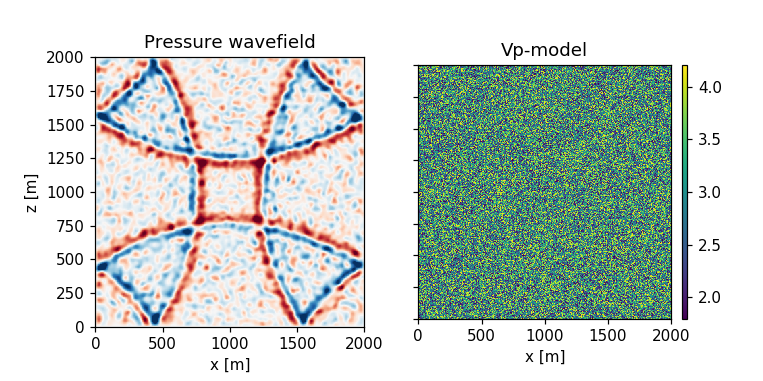

In [9]:
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

FD_2D_acoustic_JIT(dt,dx,dz,f0)

## Problem 3: Fault zone

In this problem, we model acoustic wave propagation in a vertical fault zone

In [10]:
# Fault zone model
def model(nx,nz,vp,dx,dz):
    
    vp += vp0
    vp[:, nx // 2 - 5: nx // 2 + 5] *= 0.8 
        
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


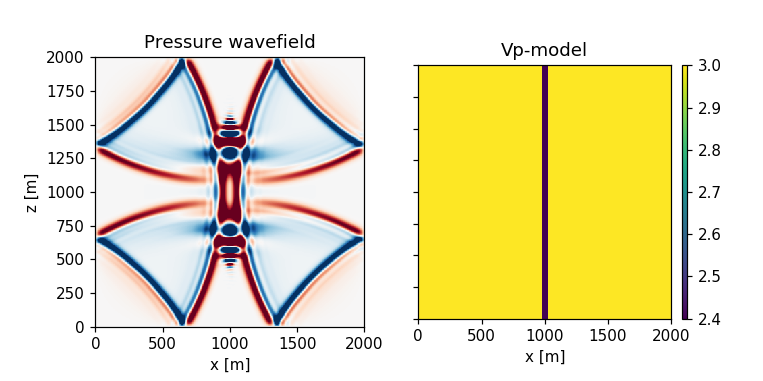

In [11]:
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

FD_2D_acoustic_JIT(dt,dx,dz,f0)

## Problem 4: Topography

How does the surface topography scatter the acoustic wavefield?

In [12]:
# Surface low velocity layer
def model(nx,nz,vp,dx,dz):
    
    vp += vp0
    vp[0 : 20, 20 : 100] = 0                         
    vp[0 : 20, 210 : 230] = 0                       
    vp[0 : 60, 290 : 340] = 0
    vp[20 : 80, 40 : 80]  = 0
    vp[0 : 30, 100 : 210] *= 0.8 
            
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


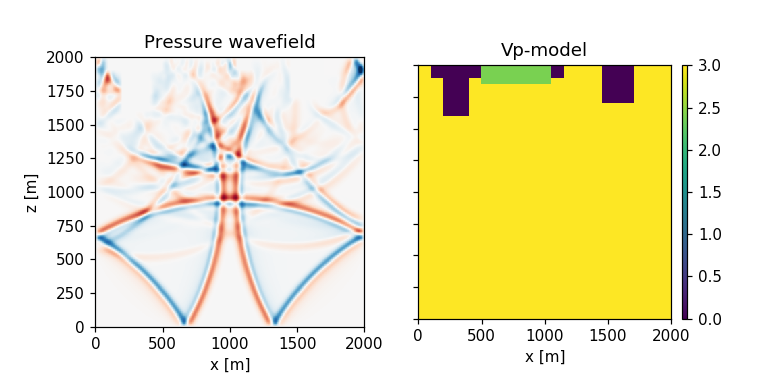

In [13]:
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

FD_2D_acoustic_JIT(dt,dx,dz,f0)

## Problem 5: Create your own problem here

Now, it's your turn ...

## What we learned:

- How to model wave propgation in simple heterogeneous 2D acoustic media 